In [3]:
%matplotlib inline

import urllib.request
import io
import zipfile

from pathlib import Path
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import igraph as ig

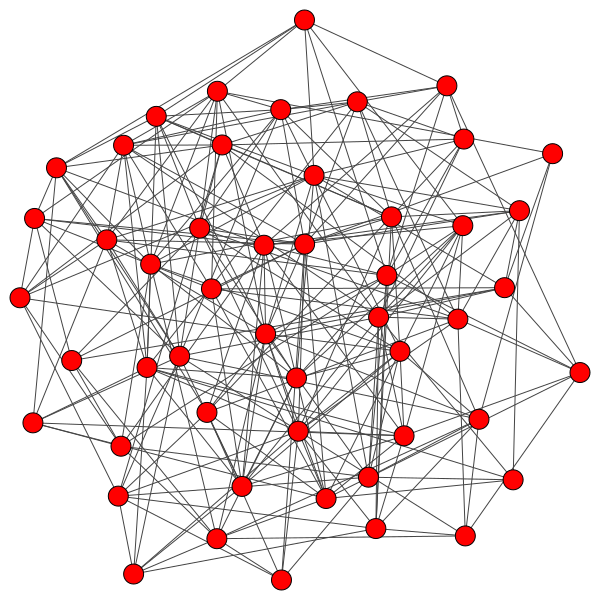

In [4]:
#instance

inst_="erdos"
GI = ig.Graph.Erdos_Renyi(n=50, p=0.2, directed=False, loops=False)
A = ig.Graph.get_edgelist(GI)
#G = nx.DiGraph(A)
G = nx.Graph(A)
#G = ig.Graph.to_networkx(GI)
ig.plot(GI)


#print("Node Degree")
#for v in G:
#    print(f"{v:4} {G.degree(v):6}")
#print(G)

In [5]:
nx.is_connected(G)

True

In [6]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

#G.edges

In [9]:
# form0
form_="form0"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status_ = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}")

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MINIMIZE)
    
    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0
 
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1*x[i]
    model.addConstr(constr0 == 1)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            model.addConstr(x[u] + x[w] >= x[s])

    #x[i].Start = 1.0
    #relax = model.relax()    
    #relax.optimize()
    
    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = model.objBound
        ub[i] = model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

In [8]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [11]:
# form1
form_="form1"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}")

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
   
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            model.addConstr(x[u] + x[w] <= 1 + x[s])

    #x[i].Start = 0.0
    #relax = model.relax()
    #relax.optimize()

    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = N - model.objBound
        ub[i] = N - model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status[i] = tmp
    else:
        ub[i] = N - model.objVal
        time[i] = model.Runtime
        status[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()

In [28]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [13]:
# indForm1

form_="indForm1"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}") #cria o modelo

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

                            Is = nx.maximal_independent_set(G, [s])
                            for k in Is:
                                constr2 = 1 * x[k]
                            model.addConstr(constr2 <= 1 + (len(Is)- 1)*x[s])
                            

    #relax = model.relax()
    #relax.optimize()

    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = N - model.objBound
        ub[i] = N - model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status[i] = tmp
    else:
        ub[i] = N - model.objVal
        time[i] = model.Runtime
        status[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()

In [ ]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [15]:
# rltForm1
form_="rltForm1"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}")

    # configurando parametros
    model.Params.TimeLimit = 3600
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    #model.Params.Presolve = 0
    #model.Params.Cuts = 0
    model.Params.LogToConsole = 0

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
        #x = []
        #for u in range(0, N):
        #   x.append(m.addVar(vtype=GRB.BINARY,name="x_{}".format(u+1)))
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")

    #l = list(tuple())
    #for u in range(0, N):
    #    for w in range(u+1, N):
    #        l.append((u,w))

    #y = model.addVars(l, vtype=GRB.BINARY, name='y')

    obj = 0
    for u in range(N):
        obj += 1 * x[u]
        #for w in range(u+1,N):
        #    obj += y[u,w]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            model.addConstr(x[u] + x[w] <= 1 + x[s])

                            if (u,w) in G.edges:
                                model.addConstr(1 <= x[u])
                                model.addConstr(1 <= x[w])
                                model.addConstr(x[u] + x[w] <= 1 + 1)
            
#            if (u,w) in G.edges:
#                model.addConstr(1 <= x[u])
#                model.addConstr(1 <= x[w])
#                model.addConstr(x[u] + x[w] <= 1 + 1)

    #x[i].Start = 0.0
    #relax = model.relax()
    #relax.optimize()

    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = N - model.objBound
        ub[i] = N - model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status[i] = tmp
    else:
        ub[i] = N - model.objVal
        time[i] = model.Runtime
        status[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()